# Exploring the information gap between formal and informal sources for women’s birth control (IUD)

### **Guide**
1. [Introduction](#Intro)
2. [Research Questions](#RQ)
3. [Data Acquisition and Cleaning](#acq)
4. [Exploratory Data Analysis](#eda)
5. [Advanced Data Processing](#process)
    1. [Sentiment Analysis](#sentiment)
        1. [Question 1](#q1)
    2. [Classification / Tokenization](#class)
        2. [Question 2](#q2)
    3. [Prediction and Evaluation](#eval)
        3. [Question 3](#q3)
6. [Conclusion](#conc)
7. [References](#ref)

In [1]:
# Install packages if necessary

#pip3 install ipympl
#pip install imblearn
#pip install wordcloud
#nltk.download("vader_lexicon")

In [2]:
# Importation all relevant modules and packages

import os
import json
import time
import requests
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup, NavigableString, Tag

# Machine Learning modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

# Text processing modules
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
# Setting parameters

%matplotlib inline
RANDOM_SEED = 300
FIGSIZE = (16, 4)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
stop_words = set(stopwords.words('english'))

<a id='Intro'></a>
## Introduction

159+ million women worldwide use an IUD as birth control and yet women's health is still under-researched. There are a few specific sources which directly attempt to address various common myths around IUDs, so women tend to turn to more informal sources to gain the knowledge they are looking for. There have been a few previous studies analyzing the discussion of women’s health on Reddit, specifically more conventionally taboo topics regarding female sexual health (i.e. female sexual dysfunction and resuming sexual activity after birth). These studies found that women received conflicting/insufficient advice from their doctors which pushed them to ask their questions on Reddit, which has been previously criticised for its encouragment of myths and rumours. It also found that women were seeking a discussion of “psychological consequences,” which they did not find from their doctors.

This project aims to explore the discussion of IUD-related information from formal and informal sources. Through careful consideration of various formal sources, such as official medical information, and from informal sources, such as Reddit forums and subreddits, we approach this discussion with the three following research questions:

<a id='RQ'></a>
### Research Questions

1. Is Reddit a postive or negative place for women to seek information on IUDs?
2. What are the information gaps between the formal and informal sources?
3. How helpful is Reddit in helping people find the information they're looking for?

### Data Description

There are 3 distinct sources of data:

1. Google Trends data for the term/s 'IUD', 'IUS', 'birth control', 'mirena', and 'kyleena'
    * Exploratory source to understand the interest in the above search terms.
2. Official Medical Information on IUD Insertion (including FAQs)
    * Main formal source.
    * We picked sources that could be considered impartial.
    * The first formal source we consult is the NHS official guidelines, a UK government sponsored source.
    * The second formal source we consult are the Mayo Clinic guidelines, a well-respected and reliable medical NGO in the US.
    * We tried to avoid sources such as Planned Parenthood and online magazines which are often seen as left-leaning and/or politically controversial.
3. r/BirthControl from Reddit API
    * We make use of Reddit's API to access posts on the server. The posts from the subreddit r/BirthControl will be our main source of informal information on IUDs; we consider it informal because any user is able to post questions or unofficial/unregulated information.
    * The Reddit API has a `flair` column, which refers to a label that Reddit users can apply to their post upon submission, which must be reviewed by the forum moderators.

<a id='acq'></a>
## Data Acquisition & Cleaning

### Google Trends


We include the Google Trends code in another notebook titled `google_trends.ipynb`. The resulting dataframe is as follows:

In [4]:
# Bring date in with read_csv (parse_date and make it index also within redad_csv)
google_trends = pd.read_csv("iud_google_trends.csv", parse_dates=[0],
                            index_col=[0], usecols=[0, 1, 2, 3, 4, 5])

**It is demonstrated that there is a base-level of constant interest in IUD-related terms within the UK. Mirena tends to be the de facto IUD provided to consumers in the UK hence the higher level of search terms compared to Kyleena, which is a product more associated with the US markets. The NHS refers to the hormonal IUD as IUS (intrauterine system), so we have included it in our search terms; however, colloquially both the copper and hormonal device are refered to as IUD.**

The spike in activity around June 2021 for the term 'IUD' is due to a public figure posting about their own experiences with the contraceptive device and their call for action regarding pain relief options.

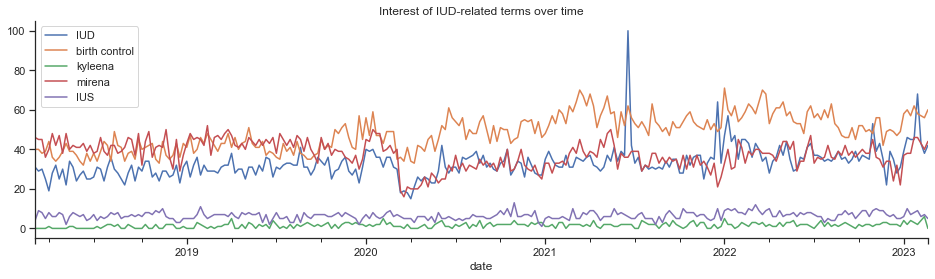

In [5]:
google_trends.plot(figsize=FIGSIZE)
plt.title('Interest of IUD-related terms over time');

In [6]:
google_trends[google_trends['IUD'] == google_trends['IUD'].max()]

,IUD,birth control,kyleena,mirena,IUS
date,,,,,
2021-06-20,100,62,2,36,6


### Scraping Official Health Data


In the following section we scrape the aforementioned "formal source" data from the NHS and Mayo Clinic website. We used two sources to avoid bias; however, we found that both were quite similar so did not include more sources. 

*Note that the NHS refers to the copper IUD as IUD; whereas, IUS (Intrauterine System) refers to the hormonal version, although both are colloquially referred to as IUD. This analysis is more focused on the hormonal IUD.*

In [7]:
def remove_punctuation(text):
    """
    Function to remove punctuation from a string of text.
    Outputs the string with all punctuation removed.
    """
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [8]:
# Creating database of stopwords without punctuation
stop_nopunc = []
for i in stop_words:
    stop_nopunc.append(remove_punctuation(i))

In [9]:
# Webscraping NHS data
url = 'https://www.nhs.uk/conditions/contraception/ius-intrauterine-system/'
r = requests.get(url)
soup = BeautifulSoup(r.content,'lxml')

# The website is structured in sections
nhs_elements = soup.find_all('section')

In [10]:
nhs_elements[1]

<section>
<h2 data-block-key="8zej9">At a glance: facts about the IUS</h2><ul><li data-block-key="k7dh4">When inserted correctly, it's more than 99% effective.</li><li data-block-key="vs0yx">It can be taken out at any time by a specially trained doctor or nurse. It's possible to get pregnant straight after it's removed.</li><li data-block-key="xys6b">It can make your periods lighter, shorter or stop altogether, so it may help people who have heavy or painful periods.</li><li data-block-key="blo8y">It can be used by people who cannot use combined contraception (such as the combined pill) – for example, those who have migraines.</li><li data-block-key="tqrcr">Once the IUS is in place, you do not have to think about it.</li><li data-block-key="zldrt">Some people may experience side effects, such as mood swings, skin problems or breast tenderness.</li><li data-block-key="qp4x4">There's a small risk of getting an infection after it's been fitted.</li><li data-block-key="5ped9">It can be unc

In [11]:
nhs_words = []

# Get all sentences
for i in nhs_elements:
    txt = str(i.get_text(separator=' ', strip =True)).lower()
    # Remove punctuation
    txt = remove_punctuation(txt)
    nhs_words.append(txt)

In [12]:
nhs_words_no_stop = []

# Remove stop words from the sentences
for sentence in nhs_words:
    temp_word_ls = sentence.split()
    for word in temp_word_ls:
        if word in stop_words:
            continue
        else:
            nhs_words_no_stop.append(word)

In [13]:
# Creation of NHS top word counts dataframe
nhs_word_counts = pd.value_counts(np.array(nhs_words_no_stop))
nhs_counts_df = pd.DataFrame(nhs_word_counts, columns = ['count'])
nhs_counts_df = nhs_counts_df.loc[nhs_counts_df['count'] > 5]

*Note that the main Mayo Clinic article about hormonal IUD's is focused specifically on Mirena (a brand of the hormonal IUD) but the information is relevant to other hormonal IUD brands. This article is a top search result on Google (disregarding possibly biased sources).*

In [14]:
# Mayo webscraping
url2 = 'https://www.mayoclinic.org/tests-procedures/mirena/about/pac-20391354'
r2 = requests.get(url2)
soup2 = BeautifulSoup(r2.content,'lxml')

# Mayo data is structured such that the information
# is all contained in one article class
content = soup2.find('article', 'id' == 'main-content')

In [15]:
# Get content and remove punctuation
mayo_str = str(content.get_text(separator=' ', strip =True)).lower()
mayo_str = remove_punctuation(mayo_str)

mayo_words = []
mayo_word_ls = mayo_str.split()

for word in mayo_word_ls:
    if word in stop_words:
        continue
        
    # Content block ends with cited studies, which we did not want in our analysis
    # the term "aug" signals the beginning of the citations & breaks out of the loop
    elif word == 'aug':
        break
    else:
        mayo_words.append(word)

In [16]:
print(mayo_words[1:50])

['overview', 'mirena', 'hormonal', 'intrauterine', 'device', 'iud', 'provide', 'longterm', 'birth', 'control', 'contraception', 'device', 'tshaped', 'plastic', 'frame', 'thats', 'inserted', 'uterus', 'releases', 'type', 'hormone', 'progestin', 'prevent', 'pregnancy', 'mirena', 'thickens', 'mucus', 'cervix', 'stop', 'sperm', 'reaching', 'fertilizing', 'egg', 'thins', 'lining', 'uterus', 'partially', 'suppresses', 'ovulation', 'mirena', 'prevents', 'pregnancy', 'seven', 'years', 'insertion', 'one', 'several', 'hormonal', 'iuds']


In [17]:
# Creation of Mayo top word counts dataframe
mayo_word_counts = pd.value_counts(np.array(mayo_words))
mayo_counts_df = pd.DataFrame(mayo_word_counts, columns = ['count'])
mayo_counts_df = mayo_counts_df.loc[mayo_counts_df['count'] > 5]

- We only include words that appeared at least 5 times in the formal text because they're more likely to be relevant to the rest of the data analysis.
- Looking at these graphs, the top words primarily concern medical officials and health care practices (note that some words are different due to cultural differences (i.e. gp vs. health care provider).
- While pain and risk are mentioned in the top 10 words of the Mayo health website, they are towards the end of the NHS graph. This indicates that the side effects of the IUD may be under emphasized on the NHS website.

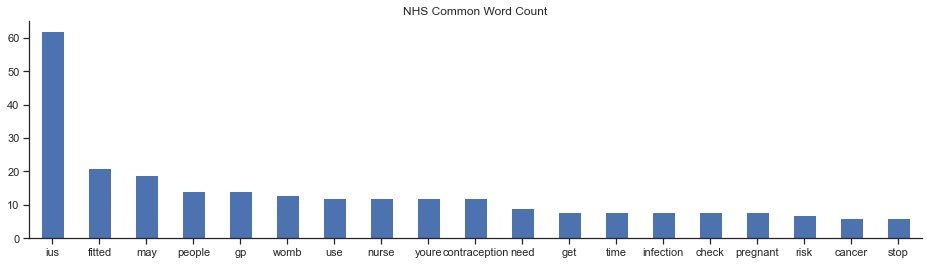

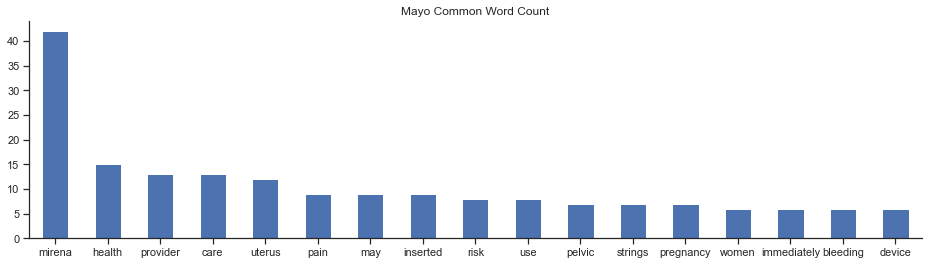

In [18]:
ax = nhs_counts_df.plot.bar(figsize = FIGSIZE, rot = 0)
ax.set_title("NHS Common Word Count")
ax.legend().remove();

ax = mayo_counts_df.plot.bar(figsize = FIGSIZE, rot = 0)
ax.set_title("Mayo Common Word Count")
ax.legend().remove();

### Reddit API


The three chosen subreddits, r/IUD, r/BirthControl and r/TwoXChromosomes, were chosen for their reputation of being open forums for female and sexual health issues.

As the process returns different values everytime it is run, we include the Reddit API code in another notebook titled `reddit_api_scraping.ipynb`. There are more details on the process of data acquisition for the Reddit API in the notebook.

The resulting dataframe is as follows:

In [19]:
# Creating/accessing reddit posts data file
file_name = "reddit_posts.csv"

if os.path.exists(file_name):
    all_posts = pd.read_csv(file_name, parse_dates=[6], dayfirst=True)
    all_posts.drop(all_posts.filter(regex="Unname"),axis=1, inplace=True)

**We continue the data cleaning process for the Reddit API data below. The following steps are taken to complete the data cleaning process:**
* Removing duplicates from the dataframe on the basis of the content in all columns (as opposed to a smaller number).
* Removing rows where there is a NaN value in the `text` field - these columns will be irrelevant once we get to the topic modelling process since there will be no content to analyse.
* Ensure that the datetime of the post is within the past five years.
* Finally, keeping only rows that contain IUD-related keywords.

In [20]:
#intentionally assigning to a copy of a slice
pd.options.mode.chained_assignment = None

# De-duplication
all_posts.drop_duplicates(inplace=True, ignore_index=True)
print('The number of distinct rows in the Reddit dataset is', all_posts.shape[0],
      'and', all_posts.shape[1], 'columns.')

# Removal of NaN rows
no_na = all_posts.dropna(axis=0, subset='text')
no_na = no_na.reset_index(drop=True)

# Removal of posts older than 5 years
five_years_ago = pd.Timestamp.now() - pd.Timedelta(days=365 * 5)
recent = no_na[no_na['datetime'] > five_years_ago]

# Splitting up datetime and adding a date column
recent["Date"] = recent["datetime"].dt.date

The number of distinct rows in the Reddit dataset is 6495 and 9 columns.


In [ ]:
for i, n in recent.iterrows():
    length = (len(n["text"]))
    recent.loc[i, 'length'] = length

In [ ]:
recent.groupby(by=["subreddit"]).count()

Before the data cleaning process we have a sample of **6495** observations (Reddit posts). **~58%** of these are from r/TwoXChromosomes, **~3%** are from r/IUD and the remaining **~40%** are from r/Birthcontrol. The proportional distribution of posts across subreddits is an accurate indicator of how active each of these subreddits are - TwoXChromosomes is the largest and most active forum, followed by Birthcontrol and then IUD as we will demonstrate in the exploratory data analysis section below. Although the number of posts from r/IUD is significantly smaller compared to the other two subreddits, the data is highly relevant to our topic.

After the data cleaning process and removal of any non-IUD-related observations we are left with a sample size of **803** rows.



In [ ]:
recent['subreddit'].value_counts(normalize=True)

In [ ]:
# IUD-related rows in text/title/category
mask = (recent['title'].str.contains("IUD|Mirena|Kyleena|Copper|IUS") | 
        recent['text'].str.contains("IUD|Mirena|Kyleena|Copper|IUS"))

iud_posts = recent[mask]
iud_posts = iud_posts.reset_index(drop=True)

print('The number of distinct rows in the Reddit dataset with IUD-related keywords is', iud_posts.shape[0],
      'and', iud_posts.shape[1], 'columns.')

In [ ]:
iud_posts['subreddit'].value_counts(normalize=True)

<a id='eda'></a>
## Exploratory Data Analysis

### Reddit Data

We explore the characteristics of the Reddit dataset obtained from the Reddit public API using relevant visualisations.

In [ ]:
fig, ax = plt.subplots(figsize=FIGSIZE)
sns.countplot(data=iud_posts, x='subreddit', order=iud_posts['subreddit'].value_counts().index)
ax.set_title('Number of Observations per Subreddit')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.show();

**`flair` refers to a label that Reddit users can apply to their post upon submission, which must be reviewed by the forum moderators.**

This visualization shows that some of the most common themes in the subreddits are related to personal experiences and side effects. The most common `flair` is "Experience" which aligns with previous literature in the field of women's health on anonymous forums. 

*As you can see here, the 'Support' `flair` from the IUD subreddit has a very low count (1)*

In [ ]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.countplot(data=iud_posts, x='flair', order=iud_posts['flair'].value_counts().index)
ax.set_title('Number of Observations per "Flair"')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.show();

**When we don't filter for IUD-related posts, the distribution of posts, average scores of posts and average number of comments are different to when we do filter for IUD-specific posts**

Below it's clear that r/TwoXChromosomes is more popular than the other two in when it comes to general activity on  subreddits. However, r/BirthControl is more engaged with IUD-related discussions which is obvious when we use data that is tailored to only IUD data.

In [ ]:
order=['TwoXChromosomes', 'birthcontrol', 'IUD']

_, ax = plt.subplots(1, 3, figsize=FIGSIZE)
sns.countplot(data=recent, x='subreddit', ax=ax[0], order=order)
ax[0].set_title('Count of Posts by Subreddit', fontsize=12)
sns.barplot(data=recent, x='subreddit', y='score', ax=ax[1], ci=None, order=order)
ax[1].set_title('Average Post Score by Subreddit', fontsize=12)
sns.barplot(data=recent, x='subreddit', y='num_comments', ax=ax[2], ci=None, order=order)
ax[2].set_title('Average Number of Comments per Post by Subreddit', fontsize=12);

_, ax = plt.subplots(1, 3, figsize=FIGSIZE)
sns.countplot(data=iud_posts, x='subreddit', ax=ax[0], order=order)
ax[0].set_title('Count of Posts by Subreddit (IUD-related)', fontsize=12)
sns.barplot(data=iud_posts, x='subreddit', y='score', ax=ax[1], ci=None, order=order);
ax[1].set_title('Average Post Score by Subreddit (IUD-related)', fontsize=12)
sns.barplot(data=iud_posts, x='subreddit', y='num_comments', ax=ax[2], ci=None, order=order)
ax[2].set_title('Average Number of Comments per Post by Subreddit (IUD-related)', fontsize=12);

**The following correlation chart shows us that popular posts (posts with a high score) are highly engaged with through more comments. Aside from that, there is little correlation between the continuous numeric variables in our dataset.**

In [ ]:
corr = iud_posts.corr()
corr.style.background_gradient()

### Reddit Posts Through Time

The following graphs show the time distribution of the Reddit posts we pull in the dataset through time. Due to constraints of the Reddit API we were limited in how many posts we could pull from each subreddit. We were able to pull the most recent posts from that subreddit until we hit maximum API limit capacity.

In [ ]:
fig, axs = plt.subplots(figsize=FIGSIZE)
ax = iud_posts.groupby(iud_posts["Date"]).size().plot(
    kind='line', rot=0, ax=axs)
ax.set_title('Distribution of all Reddit posts by Date');

**The IUD subreddit has been inactive since 2022. Most of our posts come from r/TwoXChromosomes and r/birthcontrol.**

In [ ]:
day_by_subreddit_df = pd.DataFrame(iud_posts.groupby(['Date', 'subreddit']).size())
day_by_subreddit_df = day_by_subreddit_df.unstack()
day_by_subreddit_df.columns = day_by_subreddit_df.columns.droplevel()

dates_2023 = pd.to_datetime('2022-12-31').date()

_, ax = plt.subplots(1, 2, figsize=FIGSIZE)

day_by_subreddit_df.loc[day_by_subreddit_df.index < dates_2023].plot(
    title = '2022 posts: Distribution by Date and Subreddit',
    lw=2, rot = 45, ax=ax[0])

day_by_subreddit_df.loc[day_by_subreddit_df.index > dates_2023].plot(
    title = '2023 posts: Distribution by Date and Subreddit',
    lw=2, rot = 45, ax=ax[1]);    

<a id='process'></a>
## Advanced Data Processing

The code that follows is the beginning of the advanced analytic techniques (sentiment and quantitative text analysis) that we use to investigate our research questions.

<a id='sentiment'></a>
### Sentiment Analysis

In this section we perform a quantitative sentiment analysis using VADER sentiment analysis. The VADER lexicon contains dictionaries that capture the type of and intensity of emotions. VADER is imported from the NLTK package and provides a positive, negative, neutral, and compound score for each Reddit post. We chose to use VADER because it is relatively popular within the data science community, and understands the impact of capitalization and punctuation that is often used in informal social media posts like Reddit. In our analysis we will only use the compound sentiment score, as it gives an overall score to a text's sentiment, with -1 being negative sentiment and +1 being postiive sentiment.

In [ ]:
sentiment = SentimentIntensityAnalyzer()

In [ ]:
for index, row in iud_posts.iterrows():
    text = row['text']
    score_dict =  sentiment.polarity_scores(text)
    compound_score = score_dict['compound']
    
    iud_posts.loc[index,'sentiment analysis'] = compound_score

**The following graph shows that the sentiment on Reddit is not entirely negative, but does skew slightly negative. Furthermore the most popular subreddit, r/TwoXChromosomes, appears to be the most negative because its median compound sentiment score is the lowest of all three. However all three subreddits span the sentiment score range. Therefore, the subreddits are not overtly negative.**

In [ ]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.boxplot(x="subreddit", y="sentiment analysis", notch = True, data=iud_posts)
plot.set_title('Sentiment scores by Subreddit');

**The mean sentiment score within subreddits varies overtime. This measure is very sensitive to outliers due to the small n each day. In general, sentiment averages between 0 and -0.25, which aligns with our findings in the exploratory data analysis section. Interestingly, we are also able to observe the confidence intervals for each date.** 

In [ ]:
iud_posts_2022 = iud_posts.loc[iud_posts['Date'] <= dates_2023]
iud_posts_2023 = iud_posts.loc[iud_posts['Date'] > dates_2023]

In [ ]:
_, ax = plt.subplots(1, 2, figsize=FIGSIZE)

sns.lineplot(data=iud_posts_2022, x='Date', y="sentiment analysis",
            color='green', label='IUD', ax=ax[0])
ax[0].legend();
sns.lineplot(data=iud_posts_2023, x='Date', y="sentiment analysis",
             hue='subreddit', ax=ax[1]);

**There is not a clear relationship between length and sentiment.**

It is not clear from a scatterplot below what the characteristic sentiment is for each class, either. But, we are able to recognise that there is a concentration of positive sentiment scores and another concentration of more negative sentiment scores.

In [ ]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="length", y="sentiment analysis",
                       hue="flair", data=iud_posts, s=50)
plot.set_title('Sentiment scores per flair class');

**But, when we separate each class into its own violin plot, we able to see more independent and unique distributions of sentiment scores.**

'Experience' and 'Side effects!?' have two clear clusters of posts with either positive and/or negative sentiment scores. Whereas 'Educational' and 'How to?' are less concentrated at either end of the sentiment spectrum, aligning to the more characteristics neutral information that might be shared within those sorts of posts. Finally, we observe that 'Rant!' is bottom-heavy, suggesting a predominately negative sentiment score for posts of that `flair`.

In [ ]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.violinplot(x="flair", y="sentiment analysis", data=iud_posts)
plot.set_title('Sentiment scores per flair class');

<a id='q1'></a>
### Q1: Is Reddit a postive or negative place for women to seek information on IUDs?

Women's health is widely known to be understudied and disregarded. This is likely why the Two X Chromosomes community is so strong on Reddit to begin with. However, anonymous communities have been previously criticised for their encouragment of myths and rumours. Reddit especially has a reputation for allowing hateful communities to thrive. This can be dangerous when it comes to administering medical advice, such as birth control.

Overall, the sentiment analysis skews to negative values, but not overwhelmingly so. Certain `flairs` have groups of positive and negative discussions.

<a id='class'></a>
## Classification / Tokenization

In order to perform quantitative text analysis we must separate words into stemmed tokens.

Whilst investigating `flair` classes, it was observed that the 'Support' class only has one value. This is not enough to train a model accurately for other potential 'Support' classifications. Therefore, the observation classified as 'Support' is removed altogether.

In [ ]:
# Drop rows where flair is NA
flair_na = iud_posts.dropna(subset='flair')
flair_na['flair'].value_counts()

In [ ]:
# Dropping 'support' classification as there is only one example
flair_na = flair_na.drop(flair_na[flair_na['flair'] == 'Support'].index)

# Keep relevant columns
columns = ['title', 'text', 'flair','sentiment analysis']
flair_df = flair_na[columns]

In [ ]:
#intentionally assigning to a copy of a slice
pd.options.mode.chained_assignment = None

#Preprocess text columns for vectorisation
flair_df['all_text'] = flair_df['title'].str.cat(flair_df['text'], sep=': ')
flair_df['all_text'] = flair_df['all_text'].apply(remove_punctuation)
flair_df['tokens'] = flair_df['all_text'].apply(lambda x: word_tokenize(x))
flair_df['sentences'] = flair_df['all_text'].apply(lambda x: sent_tokenize(x))
flair_df['tokens'] = flair_df['tokens'].apply(lambda x: [word for word in x if word not in stop_nopunc])
stemmer = PorterStemmer()
flair_df['tokens'] = flair_df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])
flair_df['processed_text'] = flair_df['tokens'].apply(lambda x: ' '.join(x))

# Vectorise text
vectorizer = CountVectorizer()
vectorizer.fit(flair_df['processed_text'])
document = vectorizer.transform(flair_df['processed_text'])

In [ ]:
# Creating specific dataframes for high sentiment and low sentiment scores
pos_flair_df = flair_df[flair_df['sentiment analysis'] >= 0.5]
neg_flair_df = flair_df[flair_df['sentiment analysis'] <= -0.5]

# Process strings in reddit flair data frame
pos_text = ''
neg_text = ''

for i in pos_flair_df['processed_text']:
    pos_text = pos_text + i
    
for i in neg_flair_df['processed_text']:
    neg_text = neg_text + i

**Now that we have created the tokenized text by sentiment scores, we can understand the differences in discourse and word choice for these separated groups of language.**

In [ ]:
# Generate wordclouds
pos_word_cloud = WordCloud(collocations = False, background_color = 'white').generate(pos_text)
neg_word_cloud = WordCloud(collocations = False, background_color = 'white').generate(neg_text)

# Plot word clouds on the axis defined
_, ax = plt.subplots(1, 2, figsize=FIGSIZE)

ax[0].imshow(pos_word_cloud, interpolation='bilinear')
ax[0].set_title('Positive Sentiment Scores')
ax[0].axis('off')
ax[1].imshow(neg_word_cloud, interpolation='bilinear')
ax[1].set_title('Negative Sentiment Scores')
ax[1].axis('off')
plt.show();

**The above wordclouds explore the common words from Reddit posts that are considered to have a positive sentiment (defined by posts with a 0.5 and more sentiment score) and next to it, a wordcloud from Reddit posts that are considered to have a negative sentiment (defined by posts with a -0.5 and less sentiment score).**

In the positive graph, we read more neutral language. In the negative graph, there is much stronger language such as 'pain' and 'cramp'.

In [ ]:
# Process strings
nhs_str = " ".join(i for i in nhs_words_no_stop)
formal_text = nhs_str + mayo_str

informal_text = ''
for i in flair_df['processed_text']:
    informal_text = informal_text + i

In [ ]:
# Generate wordclouds for formal and informal sources
formal_word_cloud = WordCloud(collocations = False, background_color = 'black').generate(formal_text)
informal_word_cloud = WordCloud(collocations = False, background_color = 'black').generate(informal_text)

# Plot wordclouds
_, ax = plt.subplots(1, 2, figsize=FIGSIZE)

ax[0].imshow(formal_word_cloud, interpolation='bilinear')
ax[0].set_title('Formal Sources')
ax[0].axis('off')
ax[1].imshow(informal_word_cloud, interpolation='bilinear')
ax[1].set_title('Informal Sources')
ax[1].axis('off')
plt.show()

<a id='q2'></a>
### Q2: What are the information gaps between the formal and informal sources?

Our analysis is interested in how formal and informal sources differ in information offered to web browsers. This analysis is motivated by previous literature that shows women turn to other open communities of women with similar questions. In order to have a preliminary comparison of the two sources we created two word clouds to see the difference in frequency of words between these sources.

It is clear from that word clouds have a different themes. Some big words that we see are in this word cloud that were not present in the formal source world cloud are "feel, period, pain, experi" all of which are experience words. **From this analysis, it seems that people are seeking validation for experiences that they are having with birth control that formal sources do not answer.**


<a id='eval'></a>
## Prediction and Evaluation
Now we fit the processed text data to the classifiers and evaluate our models using ROC, Precision and Recall.

In [ ]:
class_dist_unbalanced = dict()
for i, j in flair_na['flair'].value_counts().iteritems():
    class_dist_unbalanced[i] = j
    
classes = ['Educational', 'Experience', 'How to?', 'Mistake or Risk?',
           'Rant!', 'Side effects!?', 'Which Method?']

In [ ]:
X = document.toarray()
y = flair_df['flair']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

**We choose to upsample the minority classes to avoid issues surrounding imbalanced classes. All classes are randomly duplicated until we have reached the number of observations of the majority class of the test class (42, at this seed we have set).**

In [ ]:
y_test_unbal = []
for i in y_test:
    y_test_unbal.append(i)
class_dist_unbalanced_y_test = Counter(y_test_unbal)

In [ ]:
# Finding majority class
max_key = []
for key, val in class_dist_unbalanced_y_test.items():
    if len(max_key) == 0:
        max_key.extend([key, val])
    else: 
        if val > max_key[1]:
            max_key = [key, val] 
max_key

In [ ]:
# Create a DataFrame with the class distribution
class_dist_df_test = pd.DataFrame({'class': list(class_dist_unbalanced_y_test.keys()),
                   'dist': list(class_dist_unbalanced_y_test.values())})
goal_num_obvs = max_key[1]

goal_class_obvs = {c:goal_num_obvs for c in classes}

# Instantiate RandomOverSampler and fit_resample to generate the oversampled data
oversampler = RandomOverSampler(sampling_strategy = goal_class_obvs, random_state=RANDOM_SEED)
X_resampled, y_resampled = oversampler.fit_resample(X_test, y_test)

In [ ]:
print(y_resampled.value_counts())

**The classifiers were selected on the basis of performance for text analysis purposes. It is widely accepted in machine learning communities that Naive Bayes classifiers and linear models tend to perform most accurately for quantitative text analysis. A selection of these two supervised families of classifiers are utilised to investigate whether we can accurately predict `flair`.**

In [ ]:
classifiers = {"Gaussian NB": GaussianNB(),
               "Multinomial NB": MultinomialNB(),
               "Complement NB": ComplementNB(),
               "Linear SVC": SVC(kernel='linear', probability=True,
                                 random_state=RANDOM_SEED, tol=1e-5,
                                 max_iter=2000, C=0.025),
               "SVC": SVC(gamma='auto', random_state=RANDOM_SEED,
                          probability=True, max_iter=2000)}

**The performance of each classifier's multi-classes is assessed and the mean of the multi-classes is taken for each classifier. There is the potential for some valid information lost by taking the mean; for example, the classifier may predict very well for some classes but not others.**

In [ ]:
performance_dic = {}
for name, classifier in classifiers.items():
    # Fit and predict
    classifier.fit(X_train, y_train)
    y_hat = classifier.predict(X_resampled)
    
    # Create confusion matrix
    unique_label = np.unique([y_resampled, y_hat])
    cm = pd.DataFrame(confusion_matrix(y_resampled, y_hat, labels=unique_label), 
                        index=['T:{:}'.format(x) for x in unique_label], 
                        columns=['P:{:}'.format(x) for x in unique_label])
    
    # Calculate TPR, FPR for each class
    stats = {'TPR':[], 'FPR':[]}
    for i in range(cm.shape[0]):
        tp = cm.iloc[i,i]
        tn = np.sum(cm.values) - np.sum(cm.iloc[i,:]) - np.sum(cm.iloc[:,i]) + cm.iloc[i,i]
        fp = np.sum(cm.iloc[:,i]) - cm.iloc[i,i]
        fn = np.sum(cm.iloc[i,:]) - cm.iloc[i,i]
        tpr = round(tp/(tp+fn), 2)
        fpr = round(fp/(fp+tn), 2)
        stats['TPR'].append(tpr)
        stats['FPR'].append(fpr)
    
    # Creation of accuracy, tpr and fpr
    stats['Accuracy'] = accuracy_score(y_resampled, y_hat)
    performance_dic[name] = [round(stats['Accuracy'], 2),
                         round(np.mean(stats['TPR']), 2),
                         round(np.mean(stats['FPR']), 2)]

performance_df = pd.DataFrame(performance_dic, index = ['Accuracy', 'TPR', 'FPR']).T

### Performance Evaluation

Assessing each classifier using accuracy, true positive rates (TPR) and false positive rates (FPR) provides some insight into which models are classifying best.

All classifiers, but the SVC model, perform similarly. However, the Complement NB and Linear SVC have the highest accuracy and TPR scores, but perform similarly for FPR. Overall, Accuracy and TPR are very low.

In [ ]:
performance_df

In [ ]:
for name, perf in performance_df.T.items():
    acc, tpr, fpr = perf
    plt.scatter(fpr, tpr, label=f'{name} (Accuracy: {acc:.2f})', s=50)
    
plt.xlim(0,1); plt.ylim(0,1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate");

### ROC and PR Curves

- ROC curves visualize the trade-off between the TPR and FPR for our models using probability thresholds.

- Precision-Recall (PR) curves visualize the trade-off between precision and recall for our models using probability thresholds.

In [ ]:
y_hats = {}
p_hats = {}
for name, classifier in classifiers.items():
    y_hats[name] = classifier.predict(X_resampled) # Predicted labels
    p_hats[name] = classifier.predict_proba(X_resampled)[:,1] # Predicted probabilties

In [ ]:
y_test_binarized = label_binarize(y_resampled, classes=classes)

In [ ]:
auc_dic = dict()
prec_dic = dict()
recall_dic = dict()

for name, p_pred in p_hats.items():
    
    # Preparing data storage types
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    auc_ls = [[] for _ in range(len(classes))]
    prec_ls = [[] for _ in range(len(classes))]
    recall_ls = [[] for _ in range(len(classes))]
    
    # Calculate ROC and PR values for each class
    for i in range(y_test_binarized.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], p_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
        prec_dic[i], recall_dic[i], _ = precision_recall_curve(y_test_binarized[:, i], p_pred)
        auc_ls[i].append(roc_auc[i])
        prec_ls[i].append(prec_dic[i])
        recall_ls[i].append(recall_dic[i])
    auc_dic[name] = auc_ls
    prec_dic[name] = prec_ls
    recall_dic[name] = recall_ls
    
    fig, ax = plt.subplots(1, 2, figsize=FIGSIZE)

    # Plot ROC curve for each classifier
    for i, classi in zip(range(y_test_binarized.shape[1]), classes):
        ax[0].plot(fpr[i], tpr[i], lw=2, label='{0} (Area = {1:0.2f})'.format(classi, roc_auc[i]))
    ax[0].plot([0, 1], [0, 1], color='black', lw=1, linestyle='--');
    ax[0].set_xlim([-0.05, 1.0]);
    ax[0].set_ylim([0.0, 1.05]);
    ax[0].set_xlabel('False Positive Rate'); ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title(f'ROC curve: {name}')
    ax[0].legend(loc='upper left');

    # Plot PR curve for each classifier
    for i, classi in zip(range(y_test_binarized.shape[1]), classes):
        ax[1].plot(prec_dic[i], recall_dic[i], lw=2, 
                 label=f'{classi} (Avg. Prec: {average_precision_score(y_test_binarized[:, i], p_pred):.2f})')
    ax[1].plot([1, 0], [0, 1], color='black', lw=1, linestyle='--');
    ax[1].set_xlim([-0.05, 1.0]);
    ax[1].set_ylim([0.0, 1.05]);
    ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision");
    ax[1].set_title(f'PR curve: {name}')
    ax[1].legend(loc='upper right');
    plt.show();

**The results from this section show that classic text machine learning algorithms are not very good at classifying the Reddit posts by `flair`.**

It's possible that our data set was too small, but it's also possible that the flairs are somewhat bad at delineating between posts in the dataset, which means that women might encounter information that is not helpful to their goal.

<a id='q3'></a>
### Q3: How helpful is Reddit in helping people find the information they're looking for?

Presumably, people go on Reddit in search of answers to a question / support for an experience they have related to their IUD. For this reason, r/birthcontrol has created flairs to help people filter through all the posts. To answer whether or not these flairs are helpful search terms and predictor of what people are looking for, we will examine how well the flairs that are present in the r/birthcontrol subbreddit can classify other relevant IUD posts on Reddit.

The answer to this question is important because if the flairs are accurate, it would make it easier for women to find what they are looking for in terms of information / support on Reddit. If the flairs are not accurate, women could either: not find what they are looking for, which means that women need support from more reliable sources to answer their experience-related questions. Or, if a woman is looking under the "which method" or "how to" categories, they might stumble across negative information (i.e. negative side effect stories / rants) that DISCOURAGE them from getting a perfectly safe form of contraceptive which might improve their quality of life. In this case, formal sources need to increase their knowledge to capture these women before they resort to informal, unreliable forums, like Reddit.

<a id='conc'></a>
# Conclusion

In conclusion, **there is a clear gap in the information that women are looking for between the formal and informal sources related to hormonal IUDs.** Formal medical sources are focused on helping individuals find information on how to get fitted for an IUD, with little content on experiences that women may face after the fact or a support community for them to join. The majority of Reddit data focuses on experiences that people have had (positive and negative) with their IUD. **The data on Reddit does not seem to have an overtly negative tone, although there is a slight negative bias in the sentiment of the posts.**

However, women should still aim to get any medical advice about their experience/side effects from formal, medical sources. As we saw with the `flair` classification, the categories of the Reddit posts do not provide clear boundaries between educational, experiential, and rant-like content. Therefore, women may encounter posts being attributed to IUD insertion with little context of the anonymous users' other health/life conditions. **Our analysis indicates that users might struggle to get their questions answered on Reddit, and instead go down a Reddit "rabbit hole" of users' isolated experiences.**

**We recommend that governments, doctors, and medical NGOs should create a reliable source to support women after IUD insertion.** This can include but should not be limited to: 
- FAQs with common experiences that women may go through after their procedure alongside medical guidance for what to do and when to see a doctor.
- Online support groups run by medical professionals.
- Doctor moderated forums with responses to less common experiences.

**Some limitations of our analysis include:**
- Small sample size of Reddit posts
- Short timeframe due to Reddit API limitations
- Time constraints and scope of analysis limited number of formal sources that we were able to analyze.

<a id='ref'></a>
### References

**Women's Health & IUDs**
- The Journal of Sexual Medicide (https://academic.oup.com/jsm)
- Navigating return to sex: A qualitative Reddit analysis of parents’ perceptions about the timing of resuming sex after a birth (https://www.sciencedirect.com/science/article/abs/pii/S187757562200088X?fr=RR-2&ref=pdf_download&rr=7a0c6b820b3974b1)
- Contraceptive Use by Method 2019 (https://www.un.org/development/desa/pd/sites/www.un.org.development.desa.pd/files/files/documents/2020/Jan/un_2019_contraceptiveusebymethod_databooklet.pdf)
- Myths and facts about the intra-uterine device (IUD) (https://www.ippf.org/blogs/myths-and-facts-about-intra-uterine-devices)

**Data Sources**
- Reddit API (https://www.reddit.com/dev/api/)
- Google Trends API (https://trends.google.com/trends/?geo=GB)
- Google Trends Guide (https://lazarinastoy.com/the-ultimate-guide-to-pytrends-google-trends-api-with-python/)
- NHS Source (https://www.nhs.uk/conditions/contraception/ius-intrauterine-system/)
- Mayo Clinic Source (https://www.mayoclinic.org/tests-procedures/mirena/about/pac-20391354)

**Sentiment Score Analysis**
- Sentimental Analysis Using VADER (https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664)

**Quantitative Text Analysis**
- NLTK (https://www.nltk.org/api/nltk.tokenize.html)
- Text Tokenization (https://towardsdatascience.com/5-simple-ways-to-tokenize-text-in-python-92c6804edfc4#:~:text=2.-,Tokenization%20with%20NLTK,split%20a%20text%20into%20tokens)
- Three Basic Steps of Quantitative Text Analysis (https://campus.sagepub.com/blog/the-3-steps-of-qta)